In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

learning_rate = 0.1
training_epochs = 5000
display_step = 100
n_idle_epochs = 1000
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=n_idle_epochs, min_delta=0.00001)

def scheduler(epoch, lr):
    if lr <= 0.01:
        return lr
    if epoch % 200 == 0:
        return lr * 0.8
    else:
        return lr
reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

class NEPOCHLogger(tf.keras.callbacks.Callback):
    def __init__(self, per_epoch=100):
        super(NEPOCHLogger, self).__init__()
        self.seen = 0
        self.per_epoch = per_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.per_epoch == 0:
            print('Epoch {}, loss {:.8f}, accuracy {:.8f}'.format(epoch, logs['loss'], logs['acc']))

log_display = NEPOCHLogger(per_epoch=display_step)
train_data = pd.read_csv(r'two_spiral_train_data.txt', header=None, sep='\s+')
test_data = pd.read_csv(r'two_spiral_test_data.txt', header=None, sep='\s+')
train_data['class_0'] = train_data[2].apply(lambda x: 1 if x == 0 else 0)
train_data['class_1'] = train_data[2].apply(lambda x: 1 if x == 1 else 0)
test_data['class_0'] = test_data[2].apply(lambda x: 1 if x == 0 else 0)
test_data['class_1'] = test_data[2].apply(lambda x: 1 if x == 1 else 0)

train_X = tf.convert_to_tensor(np.asarray(train_data.iloc[:, 0:2]))
train_y = tf.convert_to_tensor(np.asarray(train_data.iloc[:, 2]))
test_X = tf.convert_to_tensor(np.asarray(test_data.iloc[:, 0:2]))
test_y = tf.convert_to_tensor(np.asarray(test_data.iloc[:, 2]))

model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=128, input_shape=(2,), activation='sigmoid'),
    tf.keras.layers.Dense(units=2, activation='softmax')
])

optimizer = tf.keras.optimizers.SGD(learning_rate)
# tf.keras.losses
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [25]:
history = model.fit(train_X, train_y, epochs=training_epochs, verbose=0, batch_size=16, callbacks=[log_display, reduce_lr])
print("Train Finished!", history)

# print('Final train loss: %10.8f' % history.history["loss"][-1])
# print('Final test loss: %10.8f' % model.evaluate(test_X, test_y, verbose=0)[0])
y_hat_train = model.predict(train_X, verbose=0)
y_hat_test = model.predict(test_X, verbose=0)
# abs_train_error = np.abs((tf.convert_to_tensor(np.reshape(y_hat_train, (300,2))) - tf.cast(train_y, tf.float32)).numpy())
# abs_test_error = np.abs((tf.convert_to_tensor(np.reshape(y_hat_test, (300,2))) - tf.cast(test_y, tf.float32)).numpy())
print('total number of test samples: %d' % len(test_y))
# print('number of train samples with absolute error >= 0.1: %d' % len(abs_train_error[abs_train_error >= 0.10]))
# print('number of train samples with absolute error >= 0.5: %d' % len(abs_train_error[abs_train_error >= 0.50]))
# print('number of test samples with absolute error >= 0.1: %d' % len(abs_test_error[abs_test_error >= 0.10]))
# print('number of test samples with absolute error >= 0.5: %d' % len(abs_test_error[abs_test_error >= 0.50]))
print(model.evaluate(test_X, test_y, verbose=0))
# with open('abs_test_error.txt', 'w') as f:
#     for item in abs_test_error:
#         f.write("%s\n" % item)

Epoch 0, loss 0.29336655, accuracy 0.88148147, val_accuracy 0.56666666
Epoch 100, loss 0.29193416, accuracy 0.87777776, val_accuracy 0.56666666
Epoch 200, loss 0.29184860, accuracy 0.88518518, val_accuracy 0.56666666
Epoch 300, loss 0.29310030, accuracy 0.87777776, val_accuracy 0.56666666
Epoch 400, loss 0.29222581, accuracy 0.89259261, val_accuracy 0.56666666
Epoch 500, loss 0.29115552, accuracy 0.88148147, val_accuracy 0.56666666
Epoch 600, loss 0.29267070, accuracy 0.88518518, val_accuracy 0.56666666
Epoch 700, loss 0.29054582, accuracy 0.88148147, val_accuracy 0.56666666
Epoch 800, loss 0.29100880, accuracy 0.88518518, val_accuracy 0.56666666
Epoch 900, loss 0.29139712, accuracy 0.88518518, val_accuracy 0.56666666
Epoch 1000, loss 0.29124814, accuracy 0.87777776, val_accuracy 0.56666666
Epoch 1100, loss 0.29008496, accuracy 0.88148147, val_accuracy 0.56666666
Epoch 1200, loss 0.29161558, accuracy 0.88518518, val_accuracy 0.56666666
Epoch 1300, loss 0.29099175, accuracy 0.88518518, 

In [18]:
class_0_area, class_1_area = {}, {}
for x in np.arange(-10, 10, 0.2):
    for y in np.arange(-10, 10, 0.2):
        if model.predict([[x, y]], verbose=0)[0][0] > 0.5:
            class_1_area.setdefault('x', []).append(x)
            class_1_area.setdefault('y', []).append(y)
        else:
            class_0_area.setdefault('x', []).append(x)
            class_0_area.setdefault('y', []).append(y)

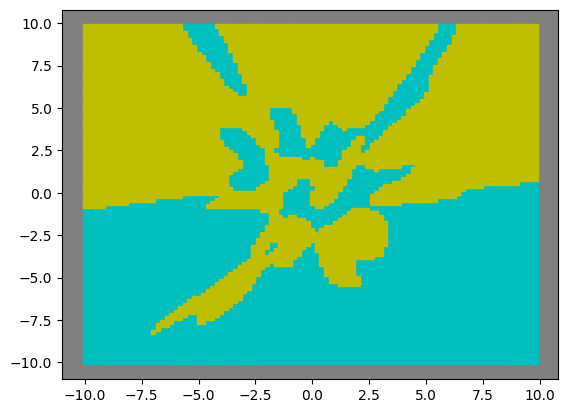

In [26]:
class_0, class_1 = {}, {}
for X, y in zip(np.concatenate([train_X.numpy(), test_X.numpy()], 0), np.concatenate([train_y.numpy(), test_y.numpy()], 0)):
    if y == 0:
        class_0.setdefault('x', []).append(X[0])
        class_0.setdefault('y', []).append(X[1])
    else:
        class_1.setdefault('x', []).append(X[0])
        class_1.setdefault('y', []).append(X[1])
plt.axes().set_facecolor('gray')
plt.plot(class_0_area['x'], class_0_area['y'], 'cs', markersize=3, label='class 0 area')
plt.plot(class_1_area['x'], class_1_area['y'], 'ys', markersize=3, label='class 1 area')
plt.plot(class_0['x'], class_0['y'], 'wo', markersize=2, label='class 0')
plt.plot(class_1['x'], class_1['y'], 'o', markersize=2, color='#000000', label='class 1')
plt.show()